In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/데이콘/유전체 정보 품종 분류

Mounted at /content/drive
/content/drive/MyDrive/데이콘/유전체 정보 품종 분류


In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import random
import os
import numpy as np
import time
from itertools import product

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

import xgboost

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
class CFG:
    SEED = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED)

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [ ]:
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class','father','mother','gender','trait'])
        df_y = df['class']

        return df_x, df_y
    else:
        df_x = df.drop(columns=['id','father','mother','gender','trait'])
        return df_x

In [ ]:
train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

In [ ]:
def make_count_snp(data):
  for a,b in list(product('AGC',repeat=2)):
    add_list = []
    for i in range(len(data)):
      add_list.append(','.join(data.iloc[i,:15].values).replace(' ','').count(a+b))
    data[a+b] = add_list

  return data

In [ ]:
train_x = make_count_snp(train_x)
test_x = make_count_snp(test_x)

In [ ]:
train_x['count_A'] = [train_x.iloc[i,:15].values.sum().count('A') for i in range(len(train_x))]
train_x['count_C'] = [train_x.iloc[i,:15].values.sum().count('C') for i in range(len(train_x))]
train_x['count_G'] = [train_x.iloc[i,:15].values.sum().count('G') for i in range(len(train_x))]

test_x['count_A'] = [test_x.iloc[i,:15].values.sum().count('A') for i in range(len(test_x))]
test_x['count_C'] = [test_x.iloc[i,:15].values.sum().count('C') for i in range(len(test_x))]
test_x['count_G'] = [test_x.iloc[i,:15].values.sum().count('G') for i in range(len(test_x))]

In [ ]:
class_le = preprocessing.LabelEncoder()
snp_le = preprocessing.LabelEncoder()
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]

In [ ]:
snp_data = []
for col in snp_col:
    snp_data += list(train_x[col].values)

train_y = class_le.fit_transform(train_y)
snp_le.fit(snp_data)

LabelEncoder()

In [ ]:
for col in train_x.columns:
    if col in snp_col:
        train_x[col] = snp_le.transform(train_x[col])
        test_x[col] = snp_le.transform(test_x[col])

In [ ]:
tX,vX,ty,vy = train_test_split(train_x,train_y,test_size=0.2,stratify=train_y,random_state=CFG.SEED)

In [ ]:
tX

,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,...,AC,GA,GG,GC,CA,CG,CC,count_A,count_C,count_G
123,1,1,0,5,0,5,5,0,5,0,...,0,2,6,0,1,0,0,13,1,16
189,5,0,2,0,0,1,0,4,0,1,...,0,1,1,0,1,0,0,23,1,6
49,0,5,0,4,0,5,5,0,4,0,...,0,3,6,0,1,0,0,14,1,15
198,5,1,2,0,3,0,0,5,4,5,...,0,2,4,0,1,0,1,15,3,12
29,1,5,0,4,0,5,5,0,4,0,...,0,2,7,0,0,0,0,13,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,5,5,3,4,2,0,0,5,0,5,...,0,1,5,0,1,0,1,15,3,12
125,5,5,2,4,3,0,0,5,0,5,...,0,2,4,0,1,0,1,17,3,10
234,5,1,2,4,3,1,0,4,0,1,...,0,2,1,0,1,0,1,19,3,8
156,5,1,3,4,3,0,0,4,0,5,...,0,2,3,0,0,0,2,16,4,10


In [ ]:
# 모델 정의
def cv_result(model,train_X,train_y,seed):
  start_time = time.time()
  train_model = model(random_state=seed)

  result = cross_validate(train_model, train_X, train_y,
                      scoring=('accuracy','f1_micro'),
                      return_train_score=True,
                      cv=5, n_jobs=-1)
  
  acc = round(np.mean(result['test_accuracy']),3)
  roc_auc = round(np.mean(result['test_f1_micro']),3)

  print("Time: {:.4f}sec".format((time.time() - start_time)))
  return acc, roc_auc


In [ ]:
lr_result = cv_result(LogisticRegression, tX,ty,CFG.SEED)
xgb_result = cv_result(xgboost.XGBClassifier,tX,ty,CFG.SEED)
rf_result = cv_result(RandomForestClassifier,tX,ty,CFG.SEED)
cab_result = cv_result(CatBoostClassifier,tX,ty,CFG.SEED)
print(f'lr : accuracy = {lr_result[0]}, f1_score = {lr_result[1]}')
print(f'xgb : accuracy = {xgb_result[0]}, f1_score = {xgb_result[1]}')
print(f'rf : accuracy = {xgb_result[0]}, f1_score = {xgb_result[1]}')
print(f'cat : accuracy = {xgb_result[0]}, f1_score = {xgb_result[1]}')


Time: 1.1965sec
Time: 1.0633sec
Time: 0.3717sec
Time: 4.4364sec
lr : accuracy = 0.904, f1_score = 0.904
xgb : accuracy = 0.919, f1_score = 0.919
rf : accuracy = 0.919, f1_score = 0.919
cat : accuracy = 0.919, f1_score = 0.919


In [ ]:
lr = LogisticRegression(random_state=CFG.SEED).fit(tX,ty)
rf = RandomForestClassifier(random_state=CFG.SEED).fit(tX,ty)
xgb = xgboost.XGBClassifier(random_state=CFG.SEED).fit(tX,ty)
cab = CatBoostClassifier(random_state=CFG.SEED,logging_level = "Silent").fit(tX,ty)

vr = VotingClassifier(estimators=[('lr',lr), ('rf',rf),('xgb',xgb),('cab',cab)],voting='soft',n_jobs=-1).fit(tX,ty)

lr_pred = lr.predict(vX)
rf_pred = rf.predict(vX)
xgb_pred = xgb.predict(vX)
cab_pred = cab.predict(vX)

vr_pred = vr.predict(vX)


lr_acc,lr_f1 = accuracy_score(lr_pred,vy) , f1_score(lr_pred,vy,average='micro')
rf_acc,rf_f1 = accuracy_score(rf_pred,vy), f1_score(rf_pred,vy,average='micro')
xgb_acc,xgb_f1 = accuracy_score(xgb_pred,vy), f1_score(xgb_pred,vy,average='micro')
cab_acc,cab_f1 = accuracy_score(cab_pred,vy), f1_score(cab_pred,vy,average='micro')

vr_acc,vr_f1 = accuracy_score(vr_pred,vy), f1_score(vr_pred,vy,average='micro')

print(f'lr : accuracy = {lr_acc}, f1_score = {lr_f1}')
print(f'rf : accuracy = {rf_acc}, f1_score = {rf_f1}')
print(f'xgb : accuracy = {xgb_acc}, f1_score = {xgb_f1}')
print(f'cat : accuracy = {cab_acc}, f1_score = {cab_f1}')
print(f'vr : accuracy = {vr_acc}, f1_score = {vr_f1}')


lr : accuracy = 0.9811320754716981, f1_score = 0.9811320754716981
rf : accuracy = 0.9056603773584906, f1_score = 0.9056603773584906
xgb : accuracy = 0.9056603773584906, f1_score = 0.9056603773584906
cat : accuracy = 0.8867924528301887, f1_score = 0.8867924528301887
vr : accuracy = 0.9056603773584906, f1_score = 0.9056603773584906


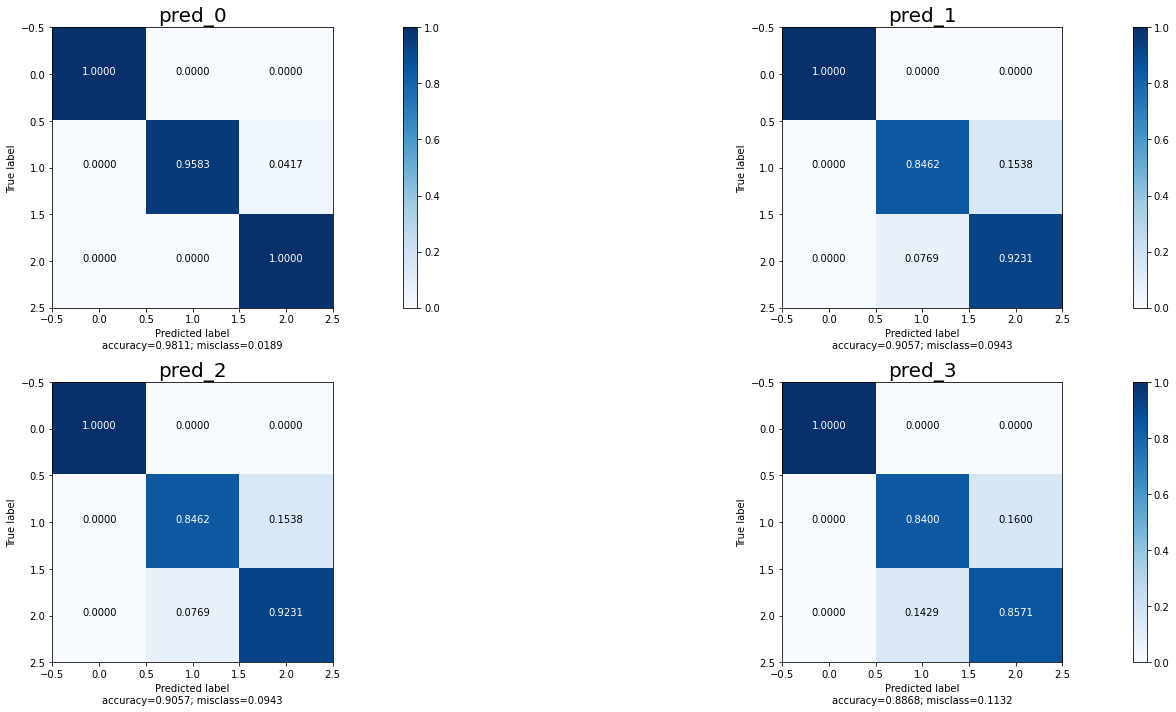

In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(pred_list,gt, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    plt.figure(figsize=(30,10))
    for idx in range(len(pred_list)):
      plt.subplot(2,2,idx+1)

      cm = confusion_matrix(pred_list[idx],gt)
      accuracy = np.trace(cm) / float(np.sum(cm))
      misclass = 1 - accuracy

      if cmap is None:
          cmap = plt.get_cmap('Blues')

      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          
      # plt.figure(figsize=(8, 6))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()

      thresh = cm.max() / 1.5 if normalize else cm.max() / 2
      
      if target_names is not None:
          tick_marks = np.arange(len(target_names))
          plt.xticks(tick_marks, target_names)
          plt.yticks(tick_marks, target_names)
      
      if labels:
          for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
              if normalize:
                  plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                          horizontalalignment="center",
                          color="white" if cm[i, j] > thresh else "black")
              else:
                  plt.text(j, i, "{:,}".format(cm[i, j]),
                          horizontalalignment="center",
                          color="white" if cm[i, j] > thresh else "black")

      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
      plt.title(f'pred_{idx}',size=20)
    plt.show()

pred_list = [lr_pred,rf_pred,xgb_pred,cab_pred]
plot_confusion_matrix(pred_list,vy)

In [ ]:
lr = LogisticRegression(random_state=CFG.SEED).fit(train_x,train_y)
rf = RandomForestClassifier(random_state=CFG.SEED).fit(train_x,train_y)
xgb = xgboost.XGBClassifier(random_state=CFG.SEED).fit(train_x,train_y)
cab = CatBoostClassifier(random_state=CFG.SEED,logging_level = "Silent").fit(train_x,train_y)

vr_soft = VotingClassifier(estimators=[('lr',lr), ('rf',rf),('xgb',xgb),('cab',cab)],voting='soft',n_jobs=-1).fit(train_x,train_y)

lr_pred = lr.predict(test_x)
rf_pred = rf.predict(test_x)
xgb_pred = xgb.predict(test_x)
cab_pred = cab.predict(test_x)

vr_soft_pred = vr_soft.predict(test_x)

In [ ]:
print(sum(xgb_pred == lr_pred) / len(xgb_pred))
print(sum(xgb_pred == rf_pred) / len(xgb_pred))
print(sum(xgb_pred == cab_pred.flatten()) / len(xgb_pred))
print(sum(rf_pred == cab_pred.flatten()) / len(xgb_pred))
print(sum(xgb_pred == vr_soft_pred) / len(xgb_pred))


0.9657142857142857
0.9828571428571429
0.9885714285714285
0.9942857142857143
0.9828571428571429


In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit['class'] = class_le.inverse_transform(lr_pred)

In [ ]:
submit.to_csv('./submit.csv', index=False)

In [ ]:
lr_submit = pd.read_csv('./submit.csv')